In [1]:
# Import all the necessary packages
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns

In [2]:
# Plot style & size defaults (OPTIONAL)
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['axes.labelsize'] = "x-large"

In [3]:
# Helper function for annotating the pair plots w/ corr coefficients.

def corr_annot(x, y, ax=None, **kws):
    """Annotate a plot w/ the correlation coefficient."""
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
    fontsizes = {range(0,21):"medium", range(21,51):'large', range(51,81):'x-large', range(90,101):'xx-large'}

    if r > 0:
        font_size = [fontsize for bound,fontsize in fontsizes.items() if round(abs(r), 1)*100 in bound][0]
        ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize = font_size)

### Read in the dataset and take a look at variable relations

In [4]:
# Read in the dataset
df_squawk_model = pd.read_csv("../data/processed/squawk7700_model.csv")

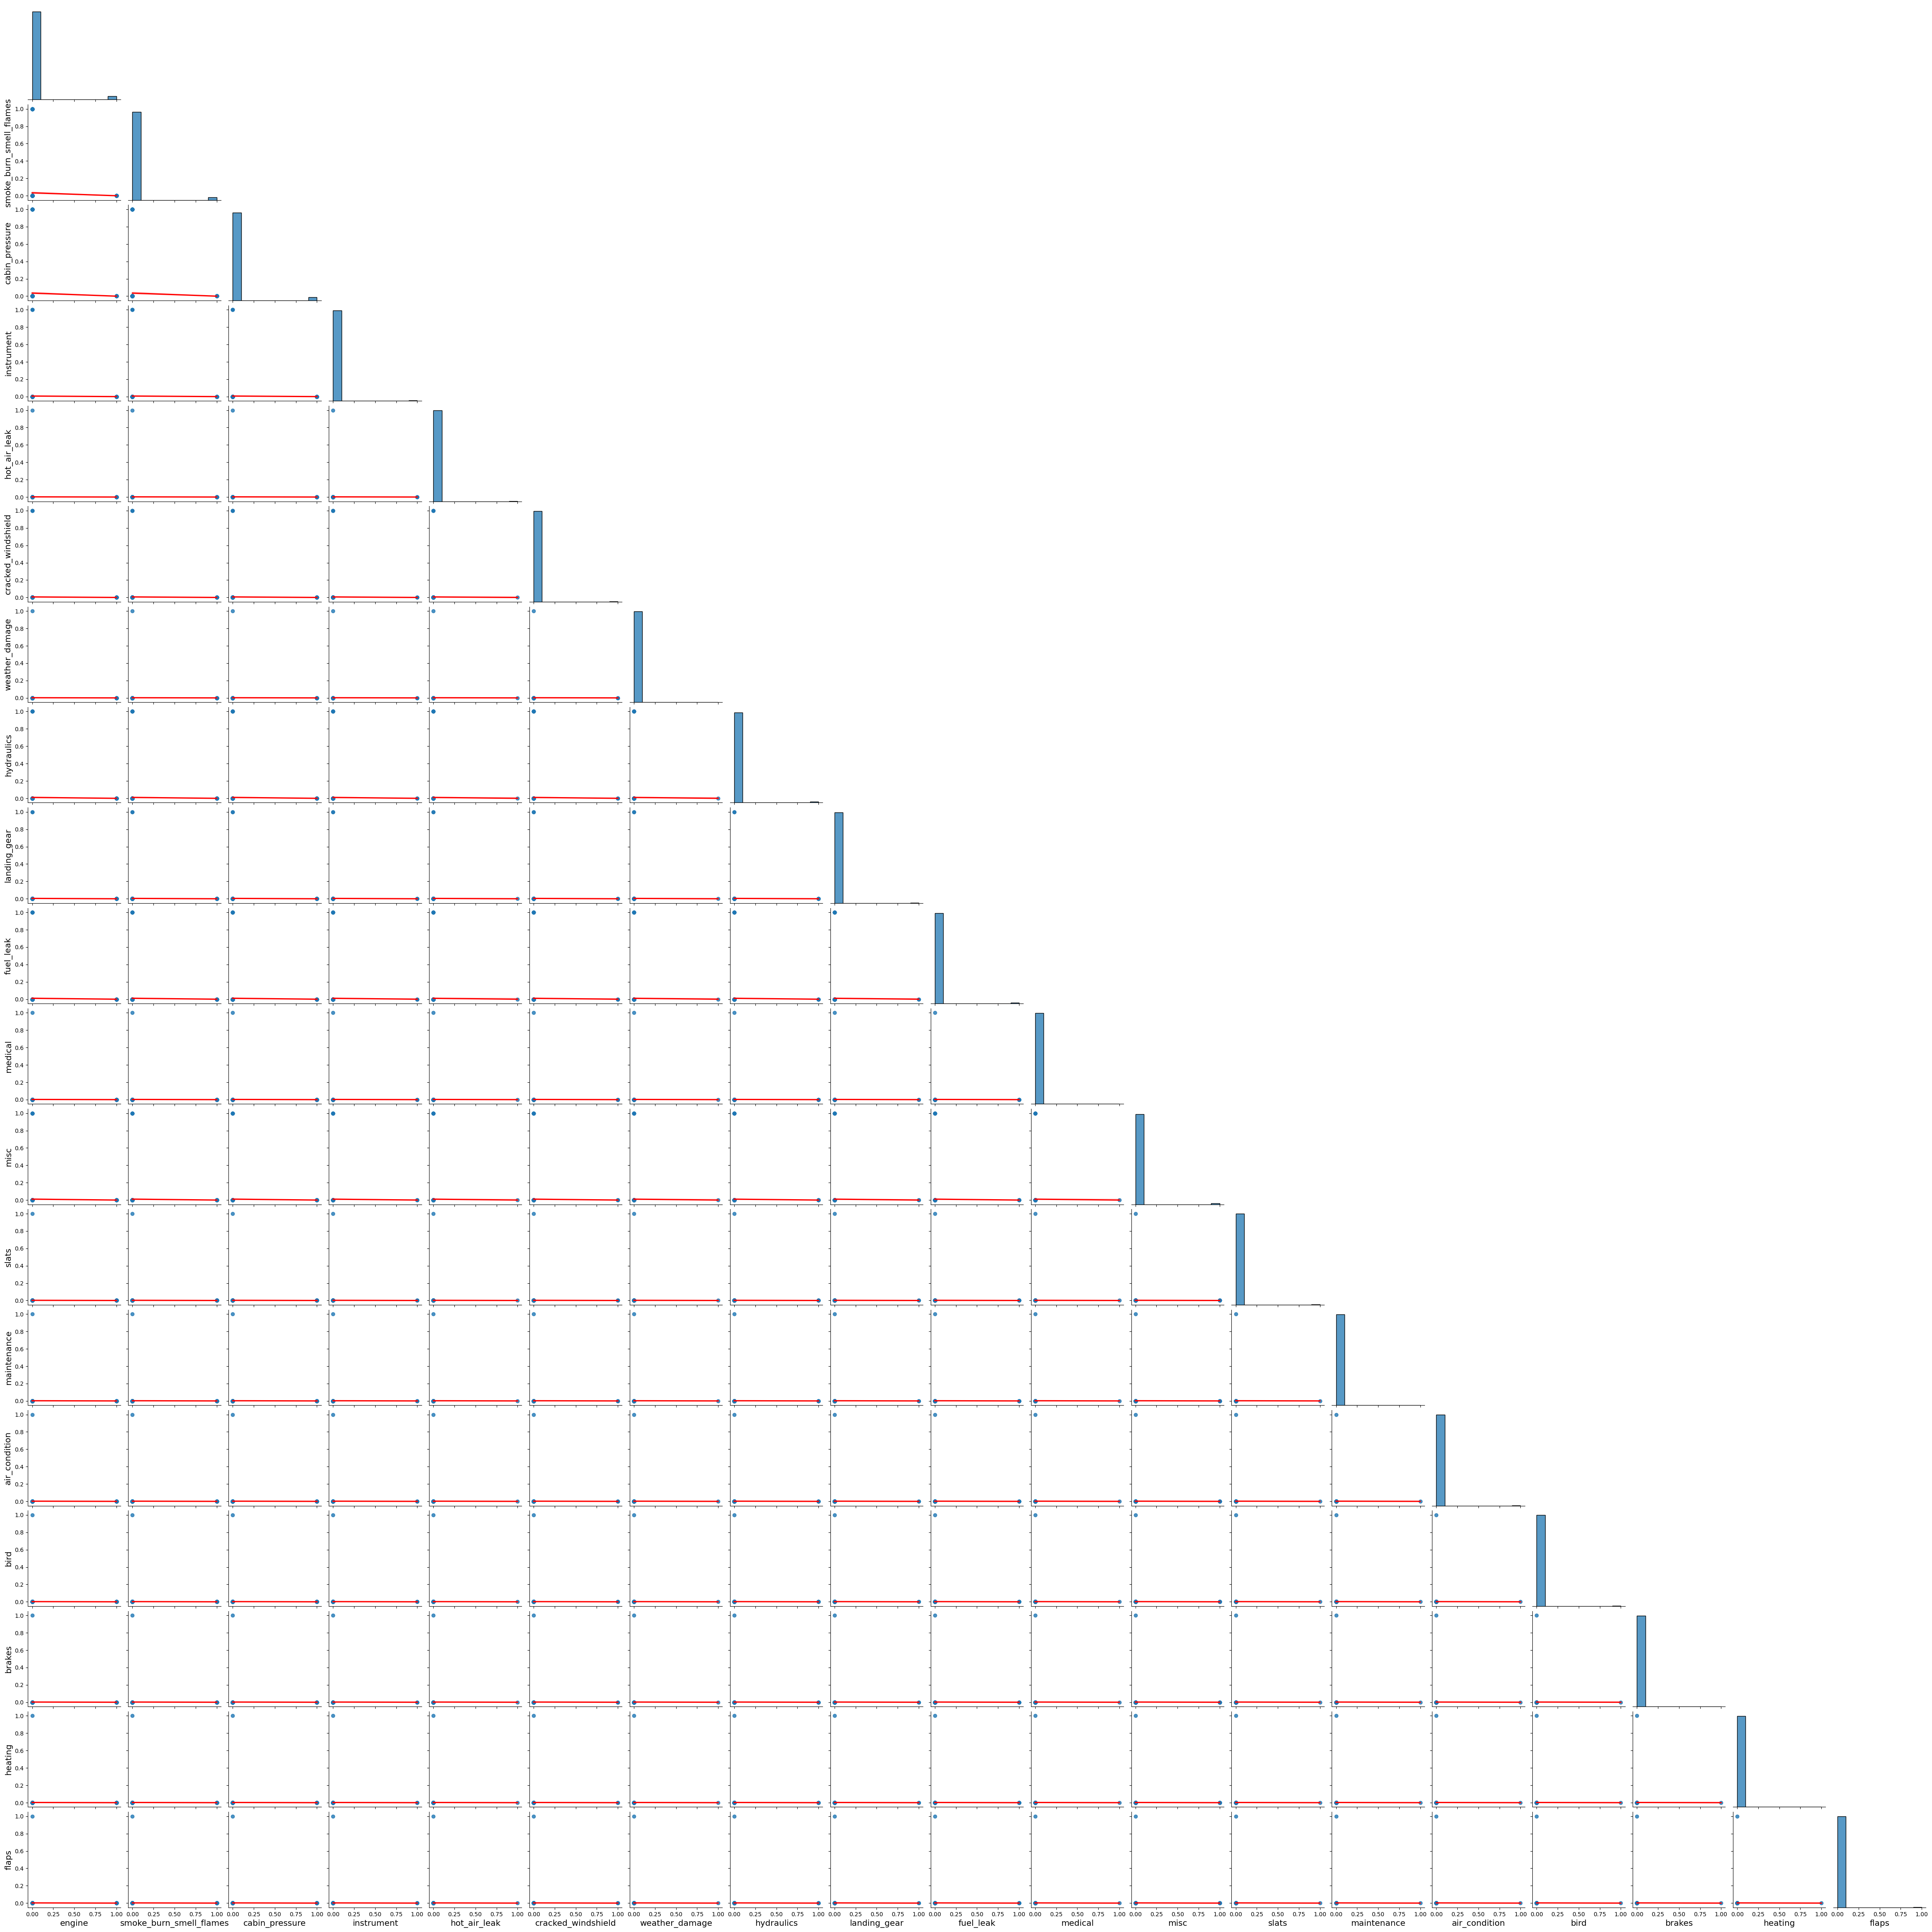

In [6]:
# Check the relationships among the explanatory variables

g = sns.pairplot(df_squawk_model.drop(columns = 'diverted'), 
                 kind = "reg",
                 corner = True,
                 plot_kws = {
                     'line_kws':{'color':'red'},
                     #'logistic':True
                     #'lowess':True
                     });

g.map_lower(corr_annot);

### Implement the logit-Binomial GLM model

In [7]:
y = df_squawk_model['diverted']
X = df_squawk_model.drop(columns = 'diverted')

# with GLM (generalized linear model)
squawk_model_all = sm.GLM(
    y,
    sm.add_constant(X),
    family=sm.families.Binomial(
        link=sm.genmod.families.links.Logit()
        )
    ).fit()

print(squawk_model_all.summary())

# We can check the AIC to evaluate the model (lower is better)
print("AIC:", squawk_model_all.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               diverted   No. Observations:                  495
Model:                            GLM   Df Residuals:                      475
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.176
Date:                 Fr, 22 Nov 2024   Deviance:                       72.353
Time:                        10:22:35   Pearson chi2:                     66.0
No. Iterations:                    25   Pseudo R-squ. (CS):             0.4723
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

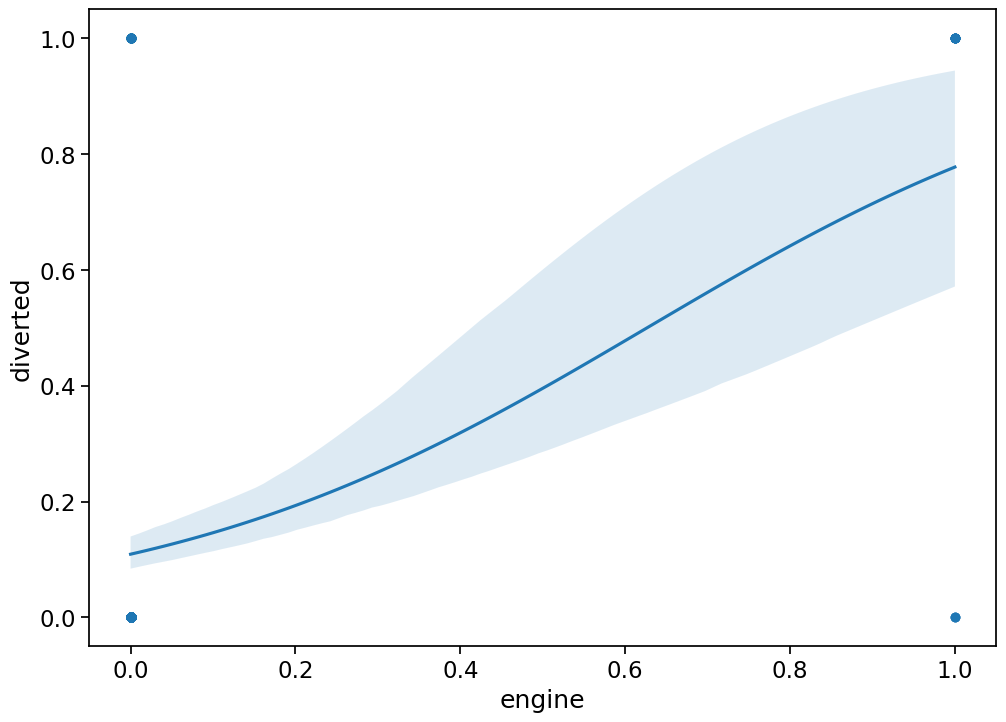

In [9]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.regplot(data = df_squawk_model, x = 'engine', y= 'diverted', logistic=True, ci=95);

### Generalized Regression Model

In [10]:
from IPython.display import clear_output

def stepwise_selection(data,
                       pred_class,
                       initial_list=[], 
                       aic_step_min = 2, 
                       #pval_threshold = 0.05, 
                       verbose=True):
    """ Perform a forward feature selection 
    based on AIC values from statsmodels.api.GLM.
    """
    
    y = data[pred_class]
    X = data.drop(columns = pred_class)
    included = list(initial_list)
    
    # Forward step
    def forward_step(y, X, included):
      old_aic = 0
      while True:
        changed = False
        excluded = list(set(X.columns)-set(included))
        new_aic = pd.Series(index=excluded, dtype='float64')
        #print(new_aic)
        if old_aic==0:
            model_old = sm.GLM(y,
                            sm.add_constant(X[included]),
                                              family=sm.families.Binomial(
                                                  link=sm.genmod.families.links.Logit()
                                                  )
                                              ).fit(method='bfgs',maxiter=1000)
            old_aic = model_old.aic
        for new_column in excluded:

            model = sm.GLM(y,
                            sm.add_constant(X[included + [new_column]]),
                                              family=sm.families.Binomial(
                                                  link=sm.genmod.families.links.Logit()
                                                  )
                                              ).fit(method='bfgs',maxiter=1000)

            new_aic[new_column] = model.aic
        best_aic = new_aic.min()
        if old_aic-best_aic > aic_step_min and len(new_aic) > 1:
            clear_output(wait=True)
            best_feature = new_aic.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} Current  AIC: {:.6}'.format(best_feature, best_aic))
            old_aic = best_aic
        if not changed:
            break
      print("Best AIC: {:.6}".format(best_aic))
      return (best_aic, included, model)

    return forward_step(y, X, included)

In [11]:
best_aic, features, model = stepwise_selection(df_squawk_model, pred_class = "diverted")
print(best_aic, features, model.params)

Add  maintenance          Current  AIC: 108.353
Best AIC: 110.353
110.35275348952655 ['engine', 'cabin_pressure', 'smoke_burn_smell_flames', 'hydraulics', 'fuel_leak', 'cracked_windshield', 'instrument', 'misc', 'landing_gear', 'brakes', 'slats', 'medical', 'heating', 'weather_damage', 'hot_air_leak', 'bird', 'maintenance'] const                     -29.169131
engine                     30.421626
cabin_pressure             30.348125
smoke_burn_smell_flames    30.267824
hydraulics                 30.555575
fuel_leak                  30.555575
cracked_windshield         81.882554
instrument                 81.882554
misc                       29.574334
landing_gear               63.765746
brakes                     40.344121
slats                      40.344121
medical                    40.344121
heating                    40.344121
weather_damage             40.344121
hot_air_leak               40.344121
bird                       40.344121
maintenance                40.344121
air_cond

/home/rmfalquier/anaconda3/envs/STATS/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:257: RuntimeWarning: divide by zero encountered in divide
  return (2 * p - 1) / v ** 2
/home/rmfalquier/anaconda3/envs/STATS/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:576: RuntimeWarning: invalid value encountered in multiply
  tmp = score_factor * tmp
/home/rmfalquier/anaconda3/envs/STATS/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rmfalquier/anaconda3/envs/STATS/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:257: RuntimeWarning: divide by zero encountered in divide
  return (2 * p - 1) / v ** 2
/home/rmfalquier/anaconda3/envs/STATS/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:576: RuntimeWarning: invalid value encountered in multip

In [12]:
print(f'Features used in best model (AIC: {best_aic}):')
print(features)
print(model.summary())
print(model.aic)

Features used in best model (AIC: 110.35275348952655):
['engine', 'cabin_pressure', 'smoke_burn_smell_flames', 'hydraulics', 'fuel_leak', 'cracked_windshield', 'instrument', 'misc', 'landing_gear', 'brakes', 'slats', 'medical', 'heating', 'weather_damage', 'hot_air_leak', 'bird', 'maintenance']
                 Generalized Linear Model Regression Results                  
Dep. Variable:               diverted   No. Observations:                  495
Model:                            GLM   Df Residuals:                      476
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                -36.176
Date:                 Fr, 22 Nov 2024   Deviance:                       72.353
Time:                        10:26:23   Pearson chi2:                     66.0
No. Iterations:                     0   Pseudo R-squ. (CS):             